In [54]:
%pip -q install matplotlib pandas scikit-learn tqdm

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from pyspark.sql import SparkSession

# Créer une session Spark en mode local
spark = SparkSession.builder \
    .appName("ctr_prediction") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://OUARAS:9000") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.executor.cores", "2") \
    .config("spark.executor.instances", "2") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .master("local[8]") \
    .getOrCreate()

print("Spark Session démarrée")

Spark Session démarrée


In [7]:
spark

In [8]:
spark.conf.set("spark.sql.pivotMaxValues", 50000)

In [9]:
sc = spark.sparkContext

## Data Organization (HDFS : HADOOP FILE SYSTEM)

### HDFS Path

In [10]:
hdfs_path = "hdfs://OUARAS:9000/ctr_prediction/"
Data_path = f"{hdfs_path}Data/"
Models_path = f"{hdfs_path}Models/"
Output_path = f"{hdfs_path}Output/"

In [11]:
# Lecture des trois fichiers depuis HDFS
train_path = f"{Data_path}ctr_train.csv"
test_path = f"{Data_path}ctr_test.csv"
submission_path = f"{Data_path}ctr_sample_submission.csv"

In [14]:
# Lecture avec inférence de schéma
df_train = spark.read.csv(train_path, header=True, inferSchema=True)

# Vérification rapide
print("=== TRAIN ===")
df_train.show(5)
df_train.printSchema()

=== TRAIN ===
+---+--------------------+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|idx|                  id|click|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|
+---+--------------------+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|  1| 1000009418151094273|    0|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22| a99f214a| ddd2926e|    44956a24|          1|               2|15706|320| 50|1722|  0| 35|    -1| 79|
|  2|10000169349117863715|    0|14102100|1005|         0|1fbe01fe|   f3845767|    

In [12]:
# Lecture avec inférence de schéma
df_test = spark.read.csv(test_path, header=True, inferSchema=True)

# Vérification rapide
print("=== TEST ===")
df_test.show(5)

=== TEST ===
+---+--------------------+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|idx|                  id|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|
+---+--------------------+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|  4|10000640724480838376|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22| a99f214a| e8275b8f|    6332421a|          1|               0|15706|320| 50|1722|  0| 35|100084| 79|
|  6|10000720757801103869|14102100|1005|         0|d6137915|   bb1ef334|     f028772b|ecad2386|  7801e8d9| 

In [13]:
# Lecture avec inférence de schéma
df_submission = spark.read.csv(submission_path, header=True, inferSchema=True)

# Vérification rapide
print("=== SUBMISSION ===")
df_submission.show(5)

=== SUBMISSION ===
+---+-----+
|idx|click|
+---+-----+
|  4| NULL|
|  6| NULL|
| 13| NULL|
| 17| NULL|
| 20| NULL|
+---+-----+
only showing top 5 rows



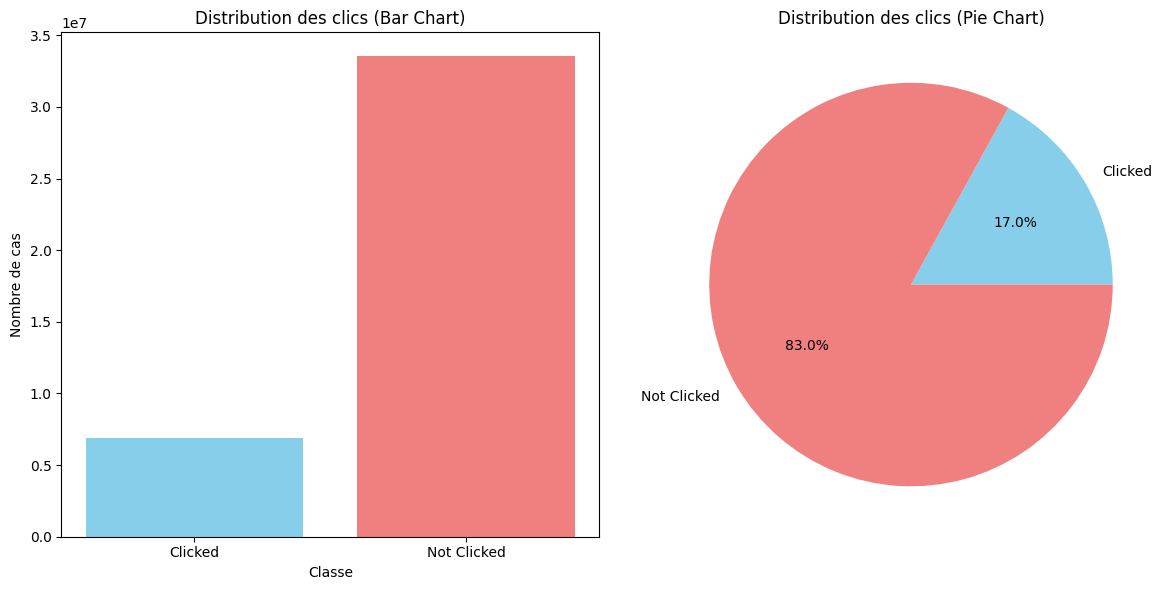

In [17]:
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt

# Ajouter une colonne descriptive
df_click_status = df_train.withColumn(
    "Click_Status",
    when(col("click") == 1, "Clicked").otherwise("Not Clicked")
)

# Compter les occurrences
class_counts = (
    df_click_status.groupBy("Click_Status")
    .count()
    .orderBy("Click_Status")
    .collect()
)

# Transformer en listes Python
labels = [row["Click_Status"] for row in class_counts]
counts = [row["count"] for row in class_counts]

# Création des graphiques
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart
ax[0].bar(labels, counts, color=["skyblue", "lightcoral"])
ax[0].set_title("Distribution des clics (Bar Chart)")
ax[0].set_xlabel("Classe")
ax[0].set_ylabel("Nombre de cas")

# Pie chart
ax[1].pie(counts, labels=labels, autopct="%1.1f%%", colors=["skyblue", "lightcoral"])
ax[1].set_title("Distribution des clics (Pie Chart)")

plt.tight_layout()
plt.show()

In [20]:
from pyspark.sql.functions import col

# Colonnes inutiles
cols_to_drop = ["idx", "id", "device_id", "device_ip"]

# Nettoyage du train
train_data_clean = (
    df_train
    .dropna()  # Supprimer toutes les lignes avec NaN / null
    .drop(*cols_to_drop)  # Supprimer colonnes inutiles
    .withColumnRenamed("click", "label")  # Renommer la cible
)

# Nettoyage du test
test_data_clean = (
    df_test
    .dropna()
    .drop(*cols_to_drop)
)

# Vérification
print("Train set :")
print(f"Lignes : {train_data_clean.count()}, Colonnes : {len(train_data_clean.columns)}")
print("Test set :")
print(f"Lignes : {test_data_clean.count()}, Colonnes : {len(test_data_clean.columns)}")

# Aperçu
train_data_clean.show(5)


Train set :
Lignes : 159968, Colonnes : 21
Test set :
Lignes : 40032, Colonnes : 20
+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|label|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|
+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|    0|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22|    44956a24|          1|               2|15706|320| 50|1722|  0| 35|    -1| 79|
|    0|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22|    711ee120|          1|               0|15704|320| 50|1722|  0| 35|100084| 79|
|    0|1410

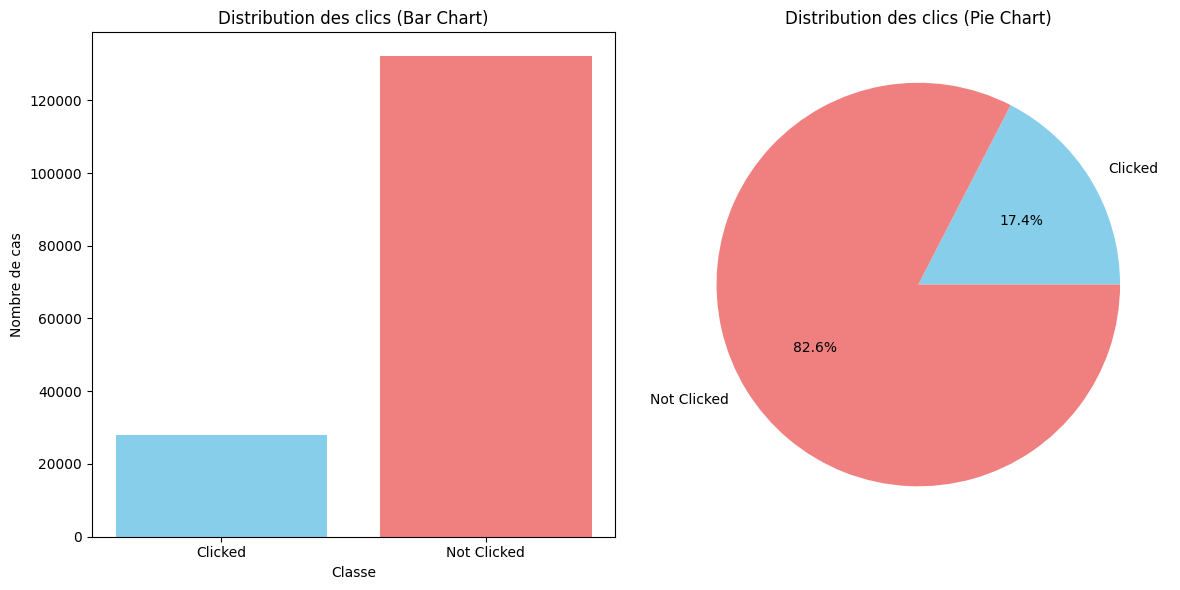

In [25]:
# Ajouter une colonne descriptive
df_click_status = train_data_clean.withColumn(
    "Click_Status",
    when(col("label") == 1, "Clicked").otherwise("Not Clicked")
)

# Compter les occurrences
class_counts = (
    df_click_status.groupBy("Click_Status")
    .count()
    .orderBy("Click_Status")
    .collect()
)

# Transformer en listes Python
labels = [row["Click_Status"] for row in class_counts]
counts = [row["count"] for row in class_counts]

# Création des graphiques
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart
ax[0].bar(labels, counts, color=["skyblue", "lightcoral"])
ax[0].set_title("Distribution des clics (Bar Chart)")
ax[0].set_xlabel("Classe")
ax[0].set_ylabel("Nombre de cas")

# Pie chart
ax[1].pie(counts, labels=labels, autopct="%1.1f%%", colors=["skyblue", "lightcoral"])
ax[1].set_title("Distribution des clics (Pie Chart)")

plt.tight_layout()
plt.show()

In [ ]:
# Compter les classes
count_clicked = df_click_status.filter(col("Click_Status") == "Clicked").count()
count_not_clicked = df_click_status.filter(col("Click_Status") == "Not Clicked").count()

# Calcul du ratio inverse
ratio = count_clicked / count_not_clicked

# Sous-échantillonnage des majoritaires
not_clicked_undersampled = df_click_status.filter(col("Click_Status") == "Not Clicked").sample(
    withReplacement=False, fraction=ratio, seed=42
)

# Union des deux classes
balanced_df = not_clicked_undersampled.union(
    df_click_status.filter(col("Click_Status") == "Clicked")
)

print("Dataset équilibré :", balanced_df.count(), "lignes")


Dataset équilibré : 55969 lignes


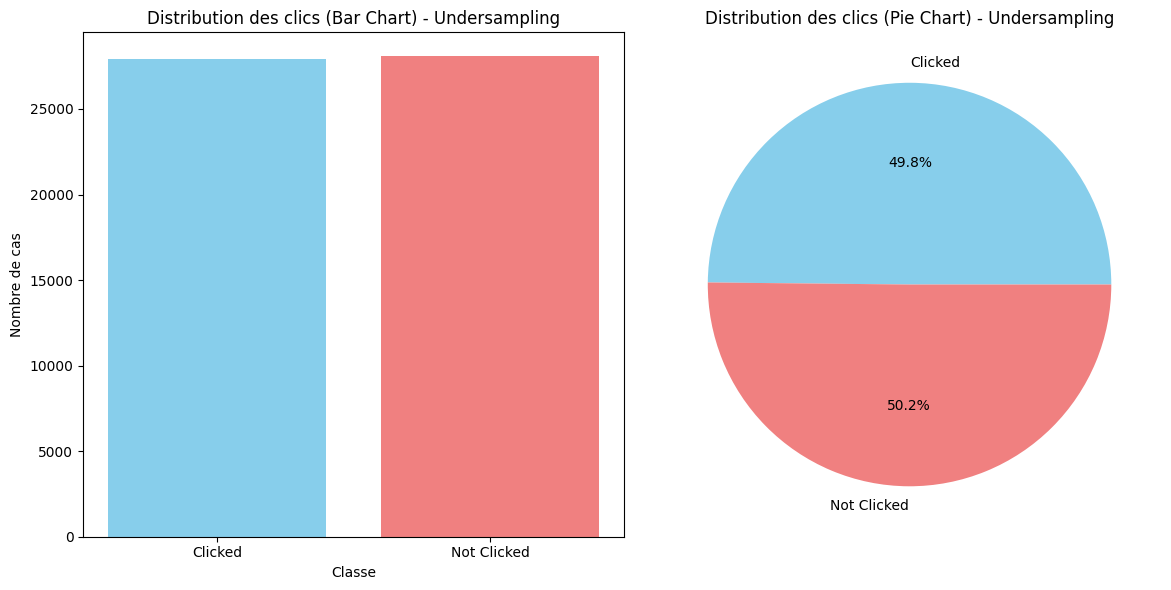

In [34]:
def plot_click_distribution(df, title):
    # Ajouter une colonne descriptive
    df_click_status = df.withColumn(
        "Click_Status",
        when(col("label") == 1, "Clicked").otherwise("Not Clicked")
    )

    # Compter les occurrences
    class_counts = (
        df_click_status.groupBy("Click_Status")
        .count()
        .orderBy("Click_Status")
        .collect()
    )

    # Transformer en listes Python
    labels = [row["Click_Status"] for row in class_counts]
    counts = [row["count"] for row in class_counts]

    # Création des graphiques
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Bar chart
    ax[0].bar(labels, counts, color=["skyblue", "lightcoral"])
    ax[0].set_title(f"Distribution des clics (Bar Chart) - {title}")
    ax[0].set_xlabel("Classe")
    ax[0].set_ylabel("Nombre de cas")

    # Pie chart
    ax[1].pie(counts, labels=labels, autopct="%1.1f%%", colors=["skyblue", "lightcoral"])
    ax[1].set_title(f"Distribution des clics (Pie Chart) - {title}")

    plt.tight_layout()
    plt.show()


# Exemple d'utilisation :
plot_click_distribution(balanced_df, "Undersampling")

In [40]:
categorical_cols = [
    "site_id", "site_domain", "site_category",
    "app_id", "app_domain", "app_category",
    "device_model"
]
numeric_cols = [
    "hour", "C1", "banner_pos", "device_type", "device_conn_type",
    "C14", "C15", "C16", "C17", "C18", "C19", "C20", "C21"
]
target_col = "label"

In [41]:
from pyspark.ml.feature import FeatureHasher

hasher = FeatureHasher(
    inputCols=categorical_cols,
    outputCol="hashed_features",
    numFeatures=2**16  # ajuster selon mémoire
)

In [42]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=numeric_cols + ["hashed_features"],  # ou one-hot features
    outputCol="features"
)

In [47]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[hasher, assembler])
model = pipeline.fit(balanced_df)
train_df_transformed = model.transform(balanced_df)
test_df_transformed = model.transform(test_data_clean)
train_df_transformed.select("features", target_col).show(5, truncate=False)
test_df_transformed.select("features").show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                           |label|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|(65549,[0,1,2,3,5,6,7,8,9,10,11,12,345,6522,21214,23905,27031,40718,46345],[1.41021E7,1005.0,1.0,1.0,17747.0,320.0,50.0,1974.0,2.0,39.0,100019.0,33.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|0    |
|(65549,[0,1,3,5,6,7,8,10,11,12,345,2686,2794,37764,40718,44106,46345],[1.41021E7,1005.0,1.0,20366.0,320.0,50.0,2333.0,39.0,-1.0,157.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                |0    |
|(65549,[0,1,2,3,5,6,7,8,10,11,12,345,21214,23905,27031,4071

In [48]:
train_df_transformed.show()

+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+------------+--------------------+--------------------+
|label|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|Click_Status|     hashed_features|            features|
+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+------------+--------------------+--------------------+
|    0|14102100|1005|         1|e151e245|   7e091613|     f028772b|ecad2386|  7801e8d9|    07d7df22|    8f5c9827|          1|               0|17747|320| 50|1974|  2| 39|100019| 33| Not Clicked|(65536,[332,6509,...|(65549,[0,1,2,3,5...|
|    0|14102100|1005|         0|543a539e|   c7ca3108|   

In [49]:
test_df_transformed.show()

+--------+----+----------+--------+-----------+-------------+--------+----------+------------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+--------------------+--------------------+
|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|     hashed_features|            features|
+--------+----+----------+--------+-----------+-------------+--------+----------+------------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+--------------------+--------------------+
|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22|    6332421a|          1|               0|15706|320| 50|1722|  0| 35|100084| 79|(65536,[332,1085,...|(65549,[0,1,3,5,6...|
|14102100|1005|         0|d6137915|   bb1ef334|     f028772b|ecad2386|  7801e8d9|    07d7df22|    8a4875bd|          1|             

In [55]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import PipelineModel
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os
from tqdm import tqdm

In [56]:
models_dict = {
    "LogisticRegression": LogisticRegression(featuresCol="features", labelCol="label", maxIter=10),
    "RandomForest": RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=50),
    "GBT": GBTClassifier(featuresCol="features", labelCol="label", maxIter=50)
}

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

results = {}

for model_name, model in tqdm(models_dict.items(), desc="Training Models"):
    # Cross-validation
    paramGrid = ParamGridBuilder().build()  # Pas de tuning ici, juste CV
    cv = CrossValidator(estimator=model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
    
    cv_model = cv.fit(train_df_transformed)
    
    # Enregistrer le modèle sur HDFS
    cv_model.bestModel.write().overwrite().save(f"{Models_path}{model_name}")
    
    # Prédictions sur le test
    pred = cv_model.transform(test_df_transformed)
    
    # Récupérer les labels et scores pour sklearn
    y_true = np.array([row['label'] for row in pred.select('label').collect()])
    y_scores = np.array([row['probability'][1] for row in pred.select('probability').collect()])
    
    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    results[model_name] = {"fpr": fpr, "tpr": tpr, "auc": roc_auc, "y_true": y_true, "y_scores": y_scores}
    
    # Plot ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.savefig(f"{Output_path}ROC_{model_name}.png")
    plt.close()
    
    # Confusion Matrix
    y_pred_label = (y_scores >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred_label)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f"{Output_path}ConfMatrix_{model_name}.png")
    plt.close()


Training Models:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize=(10,8))
for model_name in results:
    plt.plot(results[model_name]["fpr"], results[model_name]["tpr"], lw=2, label=f'{model_name} (AUC = {results[model_name]["auc"]:.2f})')
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of Models - ROC Curve')
plt.legend(loc="lower right")
plt.savefig(f"{Output_path}ROC_Comparison.png")
plt.show()
